## Baseline Performance

You will start with a model that's very effective at learning `Cats vs Dogs` without data augmentation. It's similar to the previous models that you have used. Note that there are four convolutional layers with 32, 64, 128 and 128 convolutions respectively. The code is basically the same from the previous lab so we won't go over the details step by step since you've already seen it before.

You will train only for 20 epochs to save time but feel free to increase this if you want.

In [ ]:
# Download the dataset
# !wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

In [1]:
from helper import *
import os
import sys
from pathlib import Path
import zipfile

In [2]:
import os
from pathlib import Path
import zipfile
import requests
import numpy as np

from sklearn.metrics import roc_curve


def splits(dataset, TRAIN_RATIO, VAL_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

    return train_dataset, val_dataset


def download_zip_file(url: str, save_path: Path):
    response = requests.get(url)

    fileDir, fileName = os.path.split(save_path)

    os.makedirs(fileDir, exist_ok=True)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"Download successful. File saved at {save_path}")
    else:
        print(f"Error {response.status_code}: Unable to download the file.")


def extract_zip_file(zip_file_path, extract_path):

    fileDir, fileName = os.path.split(extract_path)
    os.makedirs(fileDir, exist_ok=True)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extraction successful. Files extracted to {extract_path}")


In [6]:
url = "https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip"

zip_file_path = Path('data/cats_and_dogs.zip')
extract_path = Path('data/')

download_zip_file(url,zip_file_path)

Download successful. File saved at data\cats_and_dogs.zip


In [7]:
import os
import zipfile

# Extract the archive
zip_ref = zipfile.ZipFile(zip_file_path, 'r')
zip_ref.extractall(extract_path)
zip_ref.close()

In [8]:
# Assign training and validation set directories
base_dir = 'data/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [9]:
tr_cats = len(os.listdir(train_cats_dir))
tr_dogs = len(os.listdir(train_dogs_dir))

vl_cats = len(os.listdir(validation_cats_dir))
vl_dogs = len(os.listdir(validation_dogs_dir))

print("Length of training for CATS is ",tr_cats,"and for DOGS",tr_dogs)
print("Length of Validation for CATS is ", vl_cats, "and for DOGS",vl_dogs)

Length of training for CATS is  1000 and for DOGS 1000
Length of Validation for CATS is  500 and for DOGS 500


You will place the model creation inside a function so you can easily initialize a new one when you use data augmentation later in this notebook.

In [10]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Rescaling


def create_model():
    '''Creates a CNN with 4 convolutional layers'''
    model = tf.keras.models.Sequential([
        Rescaling(1./255, input_shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        # Use softmax activation for categorical labels
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(learning_rate=1e-4),
                  metrics=['binary_accuracy'])

    return model

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')
test_datagen = ImageDataGenerator()

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=20,
    image_size=(150, 150),
    shuffle=True,
    seed=99,
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    batch_size=20,  # CONFIGURATION["BATCH_SIZE"],
    image_size=(150, 150),
    shuffle=True,
    seed=99,
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [13]:
class_names = train_dataset.class_names
print(class_names)

['cats', 'dogs']


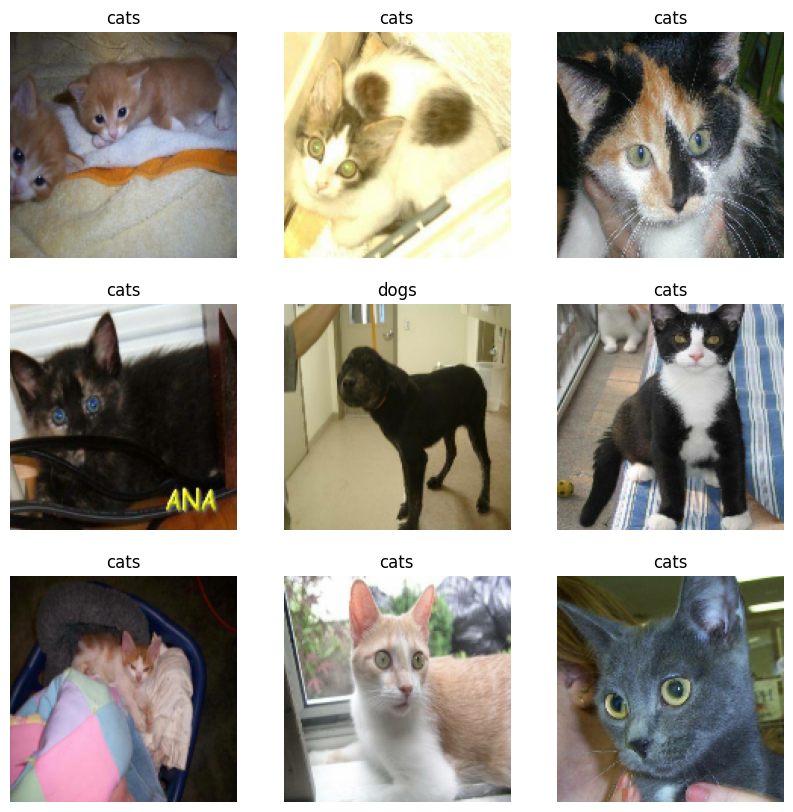

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(20, 150, 150, 3)
(20,)


In [16]:
list(train_dataset.take(1).as_numpy_iterator())[0][1].shape, list(train_dataset.take(1).as_numpy_iterator())[0][0].shape

((20,), (20, 150, 150, 3))

In [17]:
tf_2d = tf.constant(
    [[1, 2, 3],
     [1, 2, 3],
     [1, 2, 3]],
    dtype="float32",
)
tf_2d[:,-1:]

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[3.],
       [3.],
       [3.]], dtype=float32)>

In [18]:
def resize_rescale(image, label):
    image = tf.cast(image, tf.float32)
    return tf.squeeze(image), tf.squeeze(tf.squeeze(label)[:, -1:])

In [24]:
train_data = (train_dataset
              .cache()
              .shuffle(buffer_size=512, reshuffle_each_iteration=True)
              .prefetch(tf.data.AUTOTUNE))

val_data = (val_dataset
              .cache()
              .shuffle(buffer_size=512, reshuffle_each_iteration=True)
              .prefetch(tf.data.AUTOTUNE))

In [ ]:
list(train_data.take(1).as_numpy_iterator())[0][1].shape, list(train_data.take(1).as_numpy_iterator())[0][0].shape

In [25]:
# Constant for epochs
EPOCHS = 5

# Create a new model
model = create_model()

# Train the model
history = model.fit(
    train_data,
    steps_per_epoch=100,  # 2000 images = batch_size * steps
    epochs=EPOCHS,
    validation_data=val_data,
    validation_steps=50,  # 1000 images = batch_size * steps
    verbose=2)



Epoch 1/5


100/100 - 50s - loss: 0.6923 - binary_accuracy: 0.5045 - val_loss: 0.6861 - val_binary_accuracy: 0.5000 - 50s/epoch - 500ms/step
Epoch 2/5
100/100 - 43s - loss: 0.6841 - binary_accuracy: 0.5460 - val_loss: 0.6785 - val_binary_accuracy: 0.5760 - 43s/epoch - 433ms/step
Epoch 3/5
100/100 - 43s - loss: 0.6676 - binary_accuracy: 0.5900 - val_loss: 0.6544 - val_binary_accuracy: 0.6380 - 43s/epoch - 427ms/step
Epoch 4/5
100/100 - 43s - loss: 0.6450 - binary_accuracy: 0.6215 - val_loss: 0.6367 - val_binary_accuracy: 0.6400 - 43s/epoch - 428ms/step
Epoch 5/5
100/100 - 40s - loss: 0.6181 - binary_accuracy: 0.6645 - val_loss: 0.6084 - val_binary_accuracy: 0.6730 - 40s/epoch - 398ms/step


In [26]:
# Constant for epochs
EPOCHS = 5

# Create a new model
model = create_model()

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/5
100/100 - 51s - loss: 0.6938 - binary_accuracy: 0.5215 - val_loss: 0.6879 - val_binary_accuracy: 0.6080 - 51s/epoch - 506ms/step
Epoch 2/5
100/100 - 44s - loss: 0.6896 - binary_accuracy: 0.5465 - val_loss: 0.6772 - val_binary_accuracy: 0.5760 - 44s/epoch - 444ms/step
Epoch 3/5
100/100 - 53s - loss: 0.6842 - binary_accuracy: 0.5605 - val_loss: 0.6693 - val_binary_accuracy: 0.6000 - 53s/epoch - 534ms/step
Epoch 4/5
100/100 - 50s - loss: 0.6738 - binary_accuracy: 0.5805 - val_loss: 0.6567 - val_binary_accuracy: 0.5820 - 50s/epoch - 497ms/step
Epoch 5/5
100/100 - 44s - loss: 0.6639 - binary_accuracy: 0.6070 - val_loss: 0.6370 - val_binary_accuracy: 0.6360 - 44s/epoch - 444ms/step


You will then visualize the loss and accuracy with respect to the training and validation set. You will again use a convenience function so it can be reused later. This function accepts a [History](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) object which contains the results of the `fit()` method you ran above.

In [27]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [28]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['binary_accuracy']
  val_acc = history.history['val_binary_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

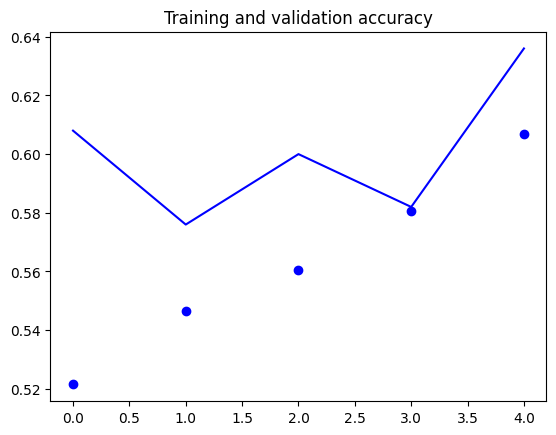

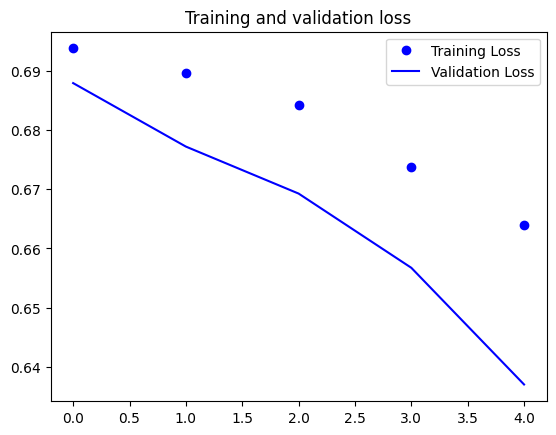

In [29]:
# Plot training results
plot_loss_acc(history)

### VGG16 Pretrained Model

In [30]:
from keras.applications.vgg16 import VGG16

In [43]:
conv_base1 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)
conv_base2 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)
conv_base3 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

In [44]:
conv_base1.trainable = True
conv_base2.trainable = False
conv_base3.trainable = False

set_trainable = False

for layer in conv_base1.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
    
# for layer in conv_base2.layers:
#     layer.trainable = False

for layer in conv_base1.layers:
  print(layer.name, layer.trainable)
for layer in conv_base2.layers:
  print(layer.name, layer.trainable)

input_11 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
input_12 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [45]:
conv_base1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [50]:
pretrained_model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    tf.keras.layers.Rescaling(1./255),
    conv_base1,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation="sigmoid"),

])
pretrained_model1.summary()
pretrained_model1.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(learning_rate=1e-4),
                  metrics=['binary_accuracy'])

pretrained_model1.fit(train_data.take(100),
                      validation_data=val_data.take(100),
                      epochs=5,
                      verbose = 2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dense_22 (Dense)            (None, 120)               983160    
                                                                 
 batch_normalization_12 (Ba  (None, 120)               480       
 tchNormalization)                                               
                                                                 
 dense_23 (Dense)            (None, 80)                9680      
                                                      

In [51]:
pretrained_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    tf.keras.layers.Rescaling(1./255),
    conv_base2,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation="sigmoid"),

])
pretrained_model2.summary()

pretrained_model2.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(learning_rate=1e-4),
                  metrics=['binary_accuracy'])

pretrained_model2.fit(train_data.take(100),
                      validation_data=val_data.take(100),
                      epochs=5,
                      verbose = 2)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 8192)              0         
                                                                 
 dense_25 (Dense)            (None, 120)               983160    
                                                                 
 batch_normalization_14 (Ba  (None, 120)               480       
 tchNormalization)                                               
                                                                 
 dense_26 (Dense)            (None, 80)                9680      
                                                      

In [56]:
inputs = tf.keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.

x = conv_base3(tf.keras.layers.Rescaling(1./255)(inputs), training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.Flatten()(x)
# A Dense classifier with a single unit (binary classification)
x =  tf.keras.layers.Dense(120, activation="relu")(x)
x =  tf.keras.layers.BatchNormalization()(x)
x =  tf.keras.layers.Dense(80, activation="relu")(x)
x =  tf.keras.layers.BatchNormalization()(x)
outputs =   tf.keras.layers.Dense(1, activation="sigmoid")(x)

pretrained_model3 = tf.keras.Model(inputs, outputs)

pretrained_model3.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(learning_rate=1e-4),
                  metrics=['binary_accuracy'])

pretrained_model3.fit(train_data.take(100), 
                      validation_data=val_data.take(100),
                      epochs=5,
                      verbose = 2)

Epoch 1/5
100/100 - 188s - loss: 0.4310 - binary_accuracy: 0.7925 - val_loss: 0.3994 - val_binary_accuracy: 0.8510 - 188s/epoch - 2s/step
Epoch 2/5
100/100 - 182s - loss: 0.1914 - binary_accuracy: 0.9330 - val_loss: 0.3164 - val_binary_accuracy: 0.8610 - 182s/epoch - 2s/step
Epoch 3/5
100/100 - 166s - loss: 0.1034 - binary_accuracy: 0.9785 - val_loss: 0.3098 - val_binary_accuracy: 0.8640 - 166s/epoch - 2s/step
Epoch 4/5
100/100 - 153s - loss: 0.0561 - binary_accuracy: 0.9960 - val_loss: 0.2950 - val_binary_accuracy: 0.8730 - 153s/epoch - 2s/step
Epoch 5/5
100/100 - 149s - loss: 0.0308 - binary_accuracy: 0.9985 - val_loss: 0.3099 - val_binary_accuracy: 0.8780 - 149s/epoch - 1s/step
